### Imports

In [1]:
import os
import sys
import time
import re

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import torch.onnx

import utils
from transformer_net import TransformerNet
from vgg import Vgg16

from tqdm.autonotebook import tqdm
from tqdm import tnrange

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Helper functions

In [31]:
def stylize(model, img, size):
    style_model = TransformerNet()
    state_dict = torch.load(model)
    for k in list(state_dict.keys()):
        if re.search(r'in\d+\.running_(mean|var)$', k):
            del state_dict[k]
    style_model.load_state_dict(state_dict)
    style_model.to(device);   
    
    with torch.no_grad():
        output = style_model(img)

    img = output[0].cpu().clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype("uint8")
    if size is not None: return Image.fromarray(img).resize((size, size), Image.ANTIALIAS)
    else: return Image.fromarray(img)

def find_lr(init_value = 1e-8, final_value=10., beta = 0.98):
    transformer = TransformerNet().to(device)
    optimizer = Adam(transformer.parameters(), 1e-3)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)

    num = len(train_loader)-1
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0
    losses = []
    lrs = []

    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=len(train_loader))        
    for i, (x, _) in progress:
        n_batch = len(x)
        batch_num += 1
         
        optimizer.zero_grad()

        x = x.to(device)
        y = transformer(x)

        y = utils.normalize_batch(y)
        x = utils.normalize_batch(x)

        features_y = vgg(y)
        features_x = vgg(x)

        content_loss = content_weight * mse_loss(features_y.relu2_2, features_x.relu2_2)

        style_loss = 0.
        for ft_y, gm_s in zip(features_y, gram_style):
            gm_y = utils.gram_matrix(ft_y)
            style_loss += mse_loss(gm_y, gm_s[:n_batch, :, :])
        style_loss *= style_weight

        loss = content_loss + style_loss
                
        l = float(loss.cpu().detach().numpy())
        avg_loss = beta * avg_loss + (1-beta) *l
        smoothed_loss = avg_loss / (1 - beta**batch_num)
        #Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss: break
        #Record the best loss
        if smoothed_loss < best_loss or batch_num==1: best_loss = smoothed_loss
        #Store the values
        losses.append(smoothed_loss)
        lrs.append(lr)
        #Do the SGD step
        loss.backward()
        optimizer.step()

        #Update the lr for the next step
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr

    lrs = pd.DataFrame({"lr": lrs, "loss": losses})

    return lrs              

### Sampling COCO to avoid training on entire dataset

In [3]:
import shutil
import random
import glob

dir = "/home/ec2-user/SageMaker/data/coco-images/test2015"
#outputdir = "/home/ec2-user/SageMaker/data/coco-sample/sample"
outputdir = "/home/ec2-user/SageMaker/data/coco-sample-small/small-sample"

if not os.path.isdir(outputdir): os.mkdir(outputdir)
#else:
#    shutil.rmtree(outputdir)
#    os.mkdir(outputdir)

sample = [file for file in os.listdir(outputdir) if os.path.isfile(os.path.join(outputdir, file))]
files = [file for file in os.listdir(dir) if os.path.isfile(os.path.join(dir, file))]
print(len(files), len(sample))

random_amount = 20000

if len(sample) >= random_amount:
    print('Enough files already!')
    pass
else:
    n = random_amount - len(sample)
    print(f'Adding {n+1} files to the sample..')
    for x in range(n):
        file = random.choice(files)
        if os.path.isfile(os.path.join(outputdir, file)): 
            pass
        else:
            shutil.copy(os.path.join(dir, file), os.path.join(outputdir, file))
    
sample = [file for file in os.listdir(outputdir) if os.path.isfile(os.path.join(outputdir, file))]
len(sample)

81434 20000
Enough files already!


20000

### Selecting style and setting key variables/hyper-parameters

In [4]:
seed = 42
image_size = 256
dataset = "/home/ec2-user/SageMaker/data/coco-sample-small"
#dataset = "/home/ec2-user/SageMaker/data/coco-sample"
batch_size = 8
lr = 3e-4
style_image = "/home/ec2-user/SageMaker/data/styles/Haring.jpg"
style_size = image_size
epochs = 1
content_weight = 1e5
style_weight = 7e8
log_interval = 250
checkpoint_interval = 2000
save_model_dir = "/home/ec2-user/SageMaker/haring"
device = torch.device("cuda")

#5e8 haring
#3e10 vangogh
#4e9 picasso

### Defining datasets and dataloaders

In [5]:
np.random.seed(seed)
torch.manual_seed(seed)

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))
])
train_dataset = datasets.ImageFolder(dataset, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

In [6]:
x, y = next(iter(train_loader)); x.shape, y.shape

(torch.Size([8, 3, 256, 256]), torch.Size([8]))

In [7]:
len(train_loader)

2500

### Defining network architecture, optimizer and loss function

In [8]:
transformer = TransformerNet().to(device)
optimizer = Adam(transformer.parameters(), lr)
mse_loss = torch.nn.MSELoss()

### Loading style image

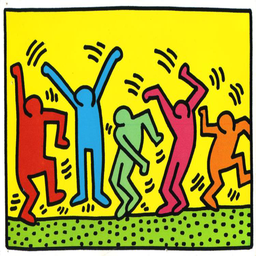

In [9]:
vgg = Vgg16(requires_grad=False).to(device)
style_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))
])
style = utils.load_image(style_image, size=style_size)
style

### Pre-calculating style features

In [10]:
style = style_transform(style)
style = style.repeat(batch_size, 1, 1, 1).to(device)
style.shape

torch.Size([8, 3, 256, 256])

In [11]:
features_style = vgg(utils.normalize_batch(style))
gram_style = [utils.gram_matrix(y) for y in features_style]

In [12]:
features_style.relu1_2.shape, features_style.relu2_2.shape, features_style.relu3_3.shape, features_style.relu4_3.shape

(torch.Size([8, 64, 256, 256]),
 torch.Size([8, 128, 128, 128]),
 torch.Size([8, 256, 64, 64]),
 torch.Size([8, 512, 32, 32]))

### Stop guessing your learning rate! Use [fast.ai LR Finder](https://docs.fast.ai/callbacks.lr_finder.html)

In [ ]:
lrs = find_lr()

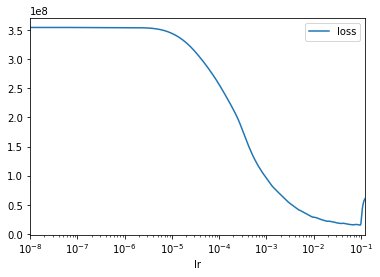

In [16]:
ax = lrs.plot(x='lr', y='loss', logx=True)

In [17]:
best_lr = 3e-4

### Update optimizer using the best learning rate + re-initialize network and dataloaders

In [20]:
transformer = TransformerNet().to(device)
optimizer = Adam(transformer.parameters(), best_lr)
mse_loss = torch.nn.MSELoss()

train_dataset = datasets.ImageFolder(dataset, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

features_style = vgg(utils.normalize_batch(style))
gram_style = [utils.gram_matrix(y) for y in features_style]

### Training loop

In [13]:
training_done = False

In [ ]:
content = []
style = []

since = time.time()
for e in range(epochs):
    transformer.train()
    agg_content_loss = 0.
    agg_style_loss = 0.
    count = 0
    for batch_id, (x, _) in enumerate(train_loader):
        n_batch = len(x)
        count += n_batch
        optimizer.zero_grad()

        x = x.to(device)
        y = transformer(x)

        y = utils.normalize_batch(y)
        x = utils.normalize_batch(x)

        features_y = vgg(y)
        features_x = vgg(x)

        content_loss = content_weight * mse_loss(features_y.relu2_2, features_x.relu2_2)

        style_loss = 0.
        for ft_y, gm_s in zip(features_y, gram_style):
            gm_y = utils.gram_matrix(ft_y)
            style_loss += mse_loss(gm_y, gm_s[:n_batch, :, :])
        style_loss *= style_weight

        total_loss = content_loss + style_loss
        style.append(float(style_loss.cpu().detach().numpy()))
        content.append(float(content_loss.cpu().detach().numpy()))
        total_loss.backward()
        optimizer.step()

        agg_content_loss += content_loss.item()
        agg_style_loss += style_loss.item()

        if (batch_id + 1) % log_interval == 0:
            time_elapsed = time.time() - since
            mesg = "Epoch {} in {:.0f}m {:.0f}s:\t[{}/{}]\tcontent: {:.6f}\tstyle: {:.6f}\ttotal: {:.6f}".format(
                e + 1, time_elapsed // 60, time_elapsed % 60, count, len(train_dataset),
                              agg_content_loss / (batch_id + 1),
                              agg_style_loss / (batch_id + 1),
                              (agg_content_loss + agg_style_loss) / (batch_id + 1)
            )
            print(mesg)

# save model
transformer.eval().cpu()
save_model_filename = "epoch_" + str(epochs) + "_" + str(time.ctime()).replace(' ', '_') + "_" + str(
    content_weight) + "_" + str(style_weight) + ".model"
save_model_path = os.path.join(save_model_dir, save_model_filename)
torch.save(transformer.state_dict(), save_model_path)

print("\nDone, trained model saved at", save_model_path)
training_done = True

Epoch 1 in 5m 37s:	[2000/20000]	content: 1268163.120750	style: 4715455.538000	total: 5983618.658750
Epoch 1 in 11m 17s:	[4000/20000]	content: 1542812.843625	style: 3457964.264000	total: 5000777.107625
Epoch 1 in 16m 57s:	[6000/20000]	content: 1658124.161750	style: 2838749.873667	total: 4496874.035417
Epoch 1 in 22m 36s:	[8000/20000]	content: 1721741.567437	style: 2445346.580000	total: 4167088.147437
Epoch 1 in 28m 15s:	[10000/20000]	content: 1760472.084850	style: 2165783.694800	total: 3926255.779650
Epoch 1 in 33m 55s:	[12000/20000]	content: 1783969.653542	style: 1955111.007875	total: 3739080.661417
Epoch 1 in 45m 15s:	[16000/20000]	content: 1806117.353906	style: 1659243.116781	total: 3465360.470688
Epoch 1 in 51m 2s:	[18000/20000]	content: 1809786.413806	style: 1553336.017361	total: 3363122.431167
Epoch 1 in 56m 48s:	[20000/20000]	content: 1810759.466425	style: 1466201.937750	total: 3276961.404175

Done, trained model saved at /home/ec2-user/SageMaker/haring/epoch_1_Wed_Jan_15_12:56:5

In [ ]:
training_done

True

### Plotting content and style losses

In [16]:
df = pd.DataFrame({'batch': np.arange(len(style)), 'content': content, 'style': style})

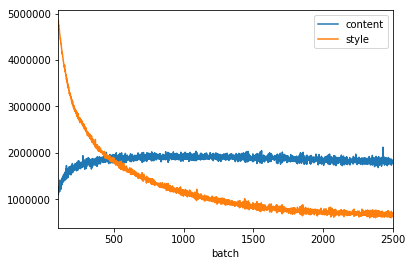

In [17]:
df[100:].plot(x='batch', y=['content', 'style'])
plt.show()

# Inference

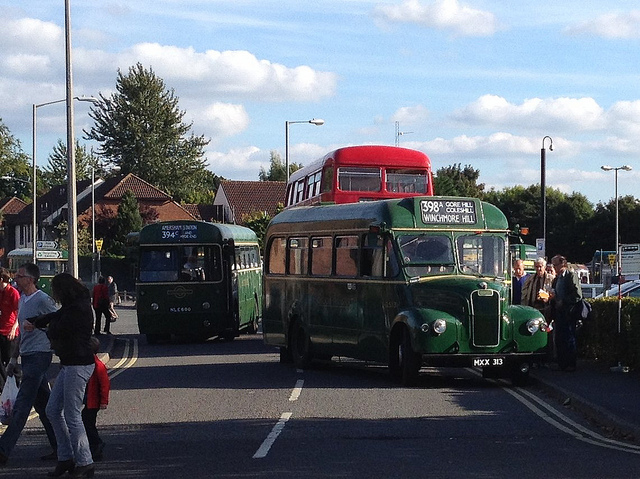

In [24]:
sample = [file for file in os.listdir(outputdir) if os.path.isfile(os.path.join(outputdir, file))]
content_image = os.path.join(outputdir, random.choice(sample))
content_image = utils.load_image(content_image)
content_image

In [25]:
content_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))
])

content_image = content_transform(content_image)
content_image = content_image.unsqueeze(0).to(device)
content_image.shape

torch.Size([1, 3, 479, 640])

### Inference with just-trained model

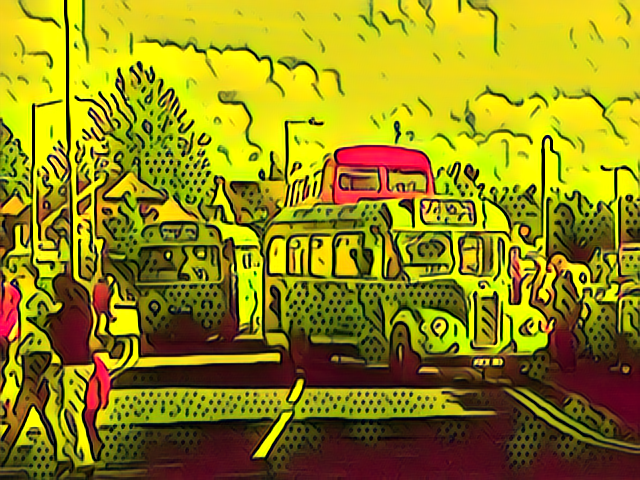

In [26]:
with torch.no_grad():
    style_model = transformer.to(device)
    output = style_model(content_image)
    
img = output[0].cpu().clone().clamp(0, 255).numpy()
img = img.transpose(1, 2, 0).astype("uint8")
img = Image.fromarray(img)
img

### Inference with already-trained models

In [36]:
models = {
    "Kandinsky, Several Circles": {
        "art": "/home/ec2-user/SageMaker/data/styles/Several_Circles.jpg",
        "model": "/home/ec2-user/SageMaker/kand/epoch_1_Sun_Jan_12_18:25:38_2020_100000.0_10000000000.0.model"
    },
    "Haring, Dance": {
        "art": "/home/ec2-user/SageMaker/data/styles/Haring.jpg",
        "model": "/home/ec2-user/SageMaker/haring/epoch_1_Wed_Jan_15_12:56:54_2020_100000.0_700000000.0.model"
    }, 
    "Van Gogh, Wheatfield with crows": {
        "art": "/home/ec2-user/SageMaker/data/styles/Wheatfield_with_crows.jpg",
        "model": "/home/ec2-user/SageMaker/vangogh/epoch_1_Tue_Jan_14_21:07:14_2020_100000.0_30000000000.0.model"
    }, 
    "Picasso, The weeping woman": {
        "art": "/home/ec2-user/SageMaker/data/styles/weeping.png",
        "model": "/home/ec2-user/SageMaker/picasso/epoch_1_Tue_Jan_14_19:03:02_2020_100000.0_4000000000.0.model"
    }
}

In [37]:
mods = [models[model] for model in models.keys()]

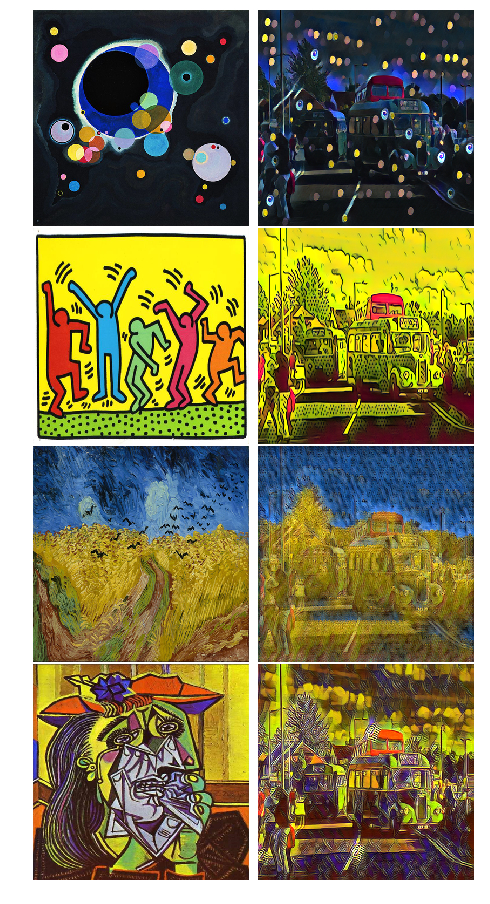

In [38]:
fig, axes = plt.subplots(4,2, figsize=(8,16))
s = 400

for i, model in enumerate(mods):
    art = utils.load_image(model['art'], size=s)
    st = stylize(model['model'], content_image, s)
    plots = [art, st]
    #print(model['art'])
    for j in range(2):
        ax = axes[i, j]
        ax.imshow(plots[j])
        ax.axis('off')
    
plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.show()